In [ ]:
def display_image(file_name):
    try:
        img = Image.open(file_name)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"An error occured: {e}")

def visualize_nearest_neighbors(selected_img_path, nearest_neighbor_paths):
    # Create a figure with two columns
    fig, axs = plt.subplots(5, 2, figsize=(10, 8))

    plt.suptitle("Recommended Items based on your selection", fontsize=16, y=1.03)

    # Display the item selected in the first column (column 0)
    selected_img = mpimg.imread(selected_img_path)
    axs[0, 0].imshow(selected_img)
    axs[0, 0].set_title("Item selected")
    axs[0, 0].axis('off')

    # Limit the number of displayed neighbors to a maximum of 10
    num_neighbors = min(len(nearest_neighbor_paths), 10)

    # Loop through the recommended items (nearest neighbors) and display them in the second column (column 1)
    for i, ax in enumerate(axs[1:].flatten(), 1):
        if i <= num_neighbors:
            neighbor_path = nearest_neighbor_paths[i - 1]
            img = mpimg.imread(neighbor_path)
            ax.imshow(img)
            ax.set_title("Recommended Item")
            ax.axis('off')

    # Hide the axis line in the second column of the first row
    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')

    # Show the images
    plt.show()

In [ ]:
!pip install barbar
!pip install faiss-cpu

In [ ]:
import zipfile
import gc
import copy
import pickle
import time
import scipy
import cv2
import torch
import torchvision
import faiss

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from pathlib import Path
from barbar import Bar
from ast import literal_eval
from PIL import Image, ImageDraw
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchsummary import summary

%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
l

In [ ]:
root_dir = '/content/drive/Othercomputers/My MacBook Pro/google-drive/ctl-dataset'

In [ ]:
train_df = pd.read_csv(root_dir + '/train_df.csv')
val_df = pd.read_csv(root_dir + '/val_df.csv')

In [ ]:
train_df['filename'] = root_dir + '/train_dataset/' + train_df['filename']
val_df['filename'] = root_dir + '/validation_dataset/' + val_df['filename']

In [ ]:
label_name_to_id = {
    'Pants': 0,
    'Handbags': 1,
    'Shirts': 2,
    'Shoes': 3,
    'Scarves': 4,
    'Jewelry': 5,
    'Skirts': 6,
    'Coats': 7,
    'Hats': 8,
    'Dresses': 9,
    'Shorts': 10,
    'Watches': 11,
    'Sunglasses': 12,
    'Jumpsuits': 13,
    'Socks': 14,
    'Rings': 15,
    'Belts': 16,
    'Gloves': 17,
    'Swimwear': 18,
    'Stockings': 19,
    'Neckties': 20
}

train_df['label_id'] = train_df['category'].map(label_name_to_id).copy()
val_df['label_id'] = val_df['category'].map(label_name_to_id).copy()

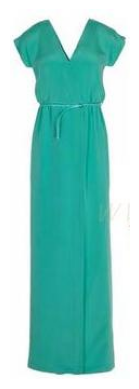

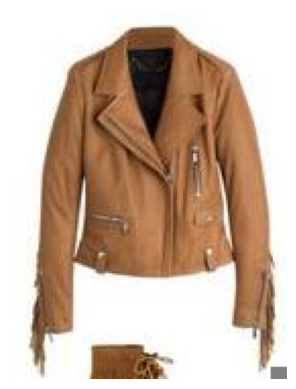

In [ ]:
display_image(train_df['filename'][20])
display_image(val_df['filename'][50])

In [ ]:
class FashionDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        row = self.df.iloc[key]
        try:
          image = Image.open(row['filename']).convert("RGB").resize((128, 128))
        except OSError as e:
          print(f"Error: {e}")
        image = self.transformations(image)
        return image

    def __len__(self):
        return len(self.df.index)

In [ ]:
train_set = FashionDataset(train_df)
val_set = FashionDataset(val_df)

In [ ]:
class FeaturizerModel(nn.Module):
    def __init__(self):
        super(FeaturizerModel, self).__init__()
        self.encoder = nn.Sequential(# in- (BS,3,128, 128)

            nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3,3),
                      stride=2,
                      padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=(3,3),
                      stride=2,
                      padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), #13

            nn.Conv2d(in_channels=256, #14
                      out_channels=512,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.ReLU(True), # 15
            nn.Conv2d(in_channels=512, #16
                      out_channels=512,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=0),
            nn.ReLU(True),            # 17
            nn.MaxPool2d(2, stride=2) # 18
        )
        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(in_channels=512, #20
                               out_channels=512,
                               kernel_size=(3,3),
                               stride=1,
                              padding=1),
            nn.ReLU(True), #22
            nn.ConvTranspose2d(in_channels=512, #23
                               out_channels=256,
                               kernel_size=(3, 3),
                               stride=2,
                               padding=0),

            nn.ConvTranspose2d(in_channels=256, #24
                               out_channels=128,
                               kernel_size=(3,3),
                               stride=2,
                               padding=1),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=(3,3),
                               stride=2,
                               padding=1),
            nn.ConvTranspose2d(in_channels=64,
                               out_channels=64,
                               kernel_size=(3,3),
                               stride=2,
                               padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64,
                               out_channels=32,
                               kernel_size=(3,3),
                               stride=2,
                               padding=1),

            nn.ConvTranspose2d(in_channels=32,
                               out_channels=32,
                               kernel_size=(3,3),
                               stride=2,
                               padding=1),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=32,
                               out_channels=3,
                               kernel_size=(4,4),
                               stride=2,
                               padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
featurizer_model = FeaturizerModel().to(device)

In [ ]:
summary(featurizer_model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 30, 30]         147,584
              ReLU-9          [-1, 128, 30, 30]               0
        MaxPool2d-10          [-1, 128, 15, 15]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
        MaxPool2d-13            [-1, 256, 4, 4]               0
           Conv2d-14            [-1, 51

In [ ]:
def load_checkpoint(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer, checkpoint['epoch']

In [ ]:
def save_checkpoint(state, filename):
    print("=> new best achieved, chechpoint saved")
    torch.save(state, filename)

In [ ]:
def train_model(model, criterion, optimizer, num_epochs):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = np.inf

  for epoch in range(1, num_epochs + 1):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print('-' * 10)

    # each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train() # set model to training mode
      else:
        model.eval() # set model to evaluation mode

      running_loss = 0.0

      # iterate over data
      for idx, inputs in enumerate(Bar(dataloaders[phase])):
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history only during training
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          loss = criterion(outputs, inputs)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # stats
        running_loss += loss.item() * inputs.size(0)

      epoch_loss = running_loss / dataset_sizes[phase]
      print(' {} Loss: {:.4f}'.format(phase, epoch_loss))

      # deepcopy the model
      if phase == 'val' and epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        save_checkpoint(state={
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'best_loss': best_loss,
            'optimizer_state_dict': optimizer.state_dict()
        }, filename='ckpt_epoch_{}.pt'.format(epoch))

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60
  ))
  print('Best val Loss: {:4f}'.format(best_loss))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, optimizer, epoch_loss

In [ ]:
EPOCHS = 40
NUM_BATCHES = 128
RETRAIN = False

dataloaders = {'train': DataLoader(train_set, batch_size=NUM_BATCHES, num_workers=2),
               'val': DataLoader(val_set, batch_size=NUM_BATCHES, num_workers=2)}

dataset_sizes = {'train': len(train_set), 'val': len(val_set)}

model = featurizer_model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
# if re-training is required
if RETRAIN == True:
    model, optimizer, state_epoch = load_checkpoint('resnet18-featurizer.pt', model, optimizer)
    print('Checkpoint Loaded')

In [ ]:
model, optimizer, loss = train_model(model=model,
                                     criterion=criterion,
                                     optimizer=optimizer,
                                     num_epochs=EPOCHS)

Epoch 1/40
----------
44998/44998: [===============================>] - ETA 0.8s
 train Loss: 0.0751
2500/2500: [==============================>.] - ETA 0.5s
 val Loss: 0.0721
=> new best achieved, chechpoint saved

Epoch 2/40
----------
44998/44998: [===============================>] - ETA 0.6s
 train Loss: 0.0696
2500/2500: [==============================>.] - ETA 0.5s
 val Loss: 0.0706
=> new best achieved, chechpoint saved

Epoch 3/40
----------
44998/44998: [===============================>] - ETA 0.7s
 train Loss: 0.0681
2500/2500: [==============================>.] - ETA 0.5s
 val Loss: 0.0693
=> new best achieved, chechpoint saved

Epoch 4/40
----------
44998/44998: [===============================>] - ETA 0.7s
 train Loss: 0.0667
2500/2500: [==============================>.] - ETA 0.8s
 val Loss: 0.0686
=> new best achieved, chechpoint saved

Epoch 5/40
----------
44998/44998: [===============================>] - ETA 0.6s
 train Loss: 0.0652
2500/2500: [=======================

In [ ]:
# save the trained model
torch.save({
    'epochs': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, 'featurizer-model-1.pt')

In [ ]:
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

In [ ]:
# load model in eval phase
model = featurizer_model.to(device)
model.load_state_dict(torch.load('featurizer-model-1.pt', map_location=device)['model_state_dict'], strict=False)
model.eval()

FeaturizerModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): Conv2